In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import CorrMaps as CM

# Load MI file

The input of DSH are so-called Multi-Image files (MIfiles). Those are raw binary files with pixel values stored line-by-line, one image after the other, with no lag in between lines or images. A header may be present: DSH will ignore it, and will skip the first N bytes of the MIfile. A MIfile always comes with a configuration (*.ini) file containing the shape of the image (in the form of a 3-integer list: [number_of_images, rows_per_image, pixels_per_row]) and eventually additional information useful to read the MIfile. A minimal configuration file would be:

```ini
[MIfile]
; MIFILE SHAPE [img_num, img_height, img_width]
shape = [2, 200, 300]
```

In addition, the section MIfile can contain the following optional keys:

```ini
; HEADER SIZE (bytes, default: 0)
hdr_len = 0
; VARIABLE FORMAT : {B (default, 8bit), h (16bit), H (16bit unsigned), i (32bit), I (32bit unsigned), f (32bit, float), d (64bit, double)}
px_format = B
; ENDIAN : {'>' (big-endian), '<' (little-endian), '' (default, system default)}
endian = >
; ACQUISITION FRAMERATE (1/s, default: 1.0)
fps = 1.0
; PIXEL SIZE (spatial units, default: 1.0)
px_size = 1.0
```

```MIfile``` class interacts with MIfiles: read them and write them, and handles metadata from external configuration files.
To load a MIfile together with associated metadata, use:

```python
mi_file = MI.MIfile(MI_filename, Metadata_filename)
```

In [2]:
froot = 'D:\\Data\\RheoSALS\\220307\\02_1.5per\\DLS'
fname = os.path.join(froot, 'Run000_DLS.raw')
metadata_fname = os.path.join(froot, 'Run000_DLS_metadata.ini')
mi_file = MI.MIfile(fname, metadata_fname)

```MIfile``` class doesn't load any data from the source MIfile upon initializion.
Data can be retrieved using one of the following functions:

```python
mi_file.Read(zRange=None, cropROI=None, closeAfter=False) #Read multiple images or ROIs from MIfile
mi_file.GetImage(img_idx, cropROI=None) #Read single image or ROI from MIfile
mi_file.GetStack(start_idx=0, imgs_num=-1) #Read contiguous image stack from MIfile
```

Here, ```cropROI``` has to be a 4-element tuple of the form: ```[x, y, w, h]```, 
where ```(x, y)``` is the coordinate of the top-left corner of the ROI (0-based) 
and ```(w, h)``` are width and height, respectively. Setting either ```w``` or ```h``` to ```-1```
indicates that the dimension extends to the image boundary.

Before any reading operation, file handle must be initialized using 

```python
mi_file.OpenForReading()
```

At the end of any reading operation, file handle must be freed using

```python
mi_file.Close()
```

### Test MIfile class

The structure of the MIfile class can be print to output in two ways:

In [3]:
mi_file

<MIfile: 0+1000x1080x1080x1 bytes>

In [4]:
print(mi_file)


|---------------|
| MIfile class: |
|---------------+---------------
| Filename      : D:\Data\RheoSALS\220307\02_1.5per\DLS\Run000_DLS.raw
| Header        : 0 bytes
| Shape         : [1000, 1080, 1080] px
| Pixel format  : B (1 bytes/px)
| Status        : Closed
|---------------+---------------


To get a feeling of what's inside the MIfile let's display one random frame:

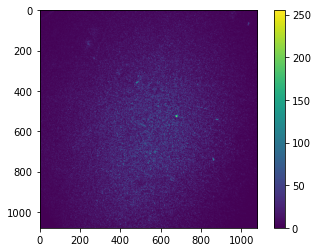

In [5]:
mi_file.OpenForReading()
sample_ROI = mi_file.GetImage(0)
plt.imshow(sample_ROI)
plt.colorbar()

Each MIfile has associated metadata, contained in a ```DSH.Config``` object:

In [6]:
mi_file.MetaData

<Config class: 2 sections, 7 keys>

In [7]:
print(mi_file.MetaData)


|---------------|
| Config class: |
|---------------+---------------
| Section count : 2
| Total keys    : 7
| MIfile        : <6 keys>
|                 hdr_len = 0
|                 px_format = B
|                 fps = 142.857
|                 px_size = 1
|                 shape = [1000, 1080, 1080]
|                 comments = raw filename: D:\Data\RheoSALS\220307\02_1.5per\DLS\Run000_DLS.raw
| settings      : <1 keys>
|                 max_buffer_size = 100000000
|---------------+---------------


```MIfile```-specific metadata can be exported as a dictionary by calling ```mi_file.GetMetadata()```:

In [8]:
mi_file.GetMetadata()

{'hdr_len': '0',
 'px_format': 'B',
 'fps': '142.857',
 'px_size': '1',
 'shape': '[1000, 1080, 1080]',
 'comments': 'raw filename: D:\\Data\\RheoSALS\\220307\\02_1.5per\\DLS\\Run000_DLS.raw'}

### Export MIfile

To export a chunk of MIfile, we can use:

```python
mi_file.Export(mi_filename, metadata_filename, zRange=None, cropROI=None)
```

Let's use it to export two cropped frames to two different files:

In [9]:
test_ROI = [200, 100, -1, 50]
for i in range(2):
    exp_mi_fname = os.path.join(froot,'MIfile_{0}.dat'.format(i+1))
    exp_meta_fname = os.path.join(froot,'metadata_{0}.ini'.format(i+1))
    mi_file.Export(exp_mi_fname, exp_meta_fname, zRange=[i, i+1], cropROI=test_ROI)

Let's test that the export was successful:

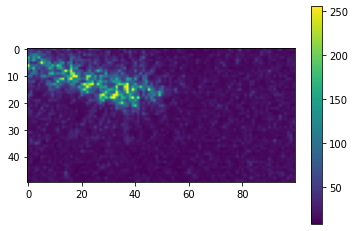

In [10]:
exp_mi_file = MI.MIfile(exp_mi_fname, exp_meta_fname)
exp_mi_file.OpenForReading()
plt.imshow(exp_mi_file.GetImage(0))
plt.colorbar()

### Non-8bit MIfile

If the pixel format is >1 byte/px, the system has to match the file endianness. This typically depends on the OS in which the file was generated. Some programs like Imagej also use a fixed endianness (Imagej uses big endian by default). If not specified, the program will take the endianness as the system default. To specify endianness, add the endian key to the MIfile secion of the metadata

In [11]:
fname_16bit = os.path.join(froot, 'MIfile16bit.dat')
metadata_16bit_fname = os.path.join(froot, 'metadata16bit.ini')
mi_file_16bit = MI.MIfile(fname_16bit, metadata_16bit_fname)

In [12]:
print(mi_file_16bit)


|---------------|
| MIfile class: |
|---------------+---------------
| Filename      : C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\test\MIfile16bit.dat
| Header        : 0 bytes
| Shape         : [5, 159, 144] px
| Pixel format  : >H (2 bytes/px)
| Status        : Closed
|---------------+---------------


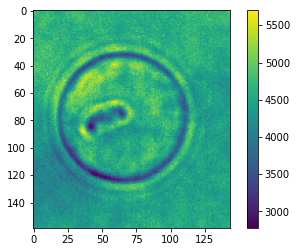

In [13]:
mi_file_16bit.OpenForReading()
sample_ROI16bit = mi_file_16bit.GetImage(0)
plt.imshow(sample_ROI16bit)
plt.colorbar()

# MIstacks

Several MIfiles with common metadata (in particular, same shape **and** image numbers are required) can be handled together as a ```MIstack``` object, that can be initialized like this:

```python
mi_stack = MIs.MIstack(MIfiles=[], MetaData=None, MetaDataSection=None, Load=False, OpenFiles=True, StackType='tau')
```

where:
- ```MIfiles``` is a list of input ```MIfile``` objects
- ```MetaData``` (```str``` or ```dict```) is the metadata common to all MIfiles. If ```string```, it is interpreted as the filename of metadata file.
- ```MetaDataSection``` (```str``` or ```None```) denotes the section to be loaded (```None``` loads all sections)
- ```StackType``` ```{'tau', 't'}``` indicates whether the MIfiles are meant to be concatenated along the time (z) axis (stack type ```'t'```) or to be stacked along an additional dimension (stack type ```'tau'```, default)

A practical way to load multiple MIfiles in the same folder is through the function

```python
mi_stack = MIs.LoadFolder(mi_folder, config_fname, config_section='MIfile', mi_prefix='', mi_ext='.dat', mi_sort='ASC', open_mifiles=True, stack_type='tau')
```

In [14]:
mi_stack = MIs.LoadFolder(froot, exp_meta_fname, mi_prefix='MIfile_', stack_type='t')
mi_stack

<MIstack [t]: 2x1x50x100x1 bytes>

In [15]:
print(mi_stack)


|----------------|
| MIstack class: |
|----------------+---------------
| MIfile number  : 2
| MIshape        : [1, 50, 100] px
| Image number   : 2
| Pixel format   : B (1 bytes/px)
| Stack type     : t
|----------------+---------------


There are 2 images, which can be accessed with a ```GetImage()``` method analogous to the ```MIfile``` one:

```python
MIs.MIstack.GetImage(img_idx, MI_idx=None, cropROI=None)
```

where ```MI_idx``` indicates the index of the ```MIfile```. If it is ```None``` (default), ```img_idx``` ranges from 0 to ```mi_stack.ImageNumber()``` and is interpreted as the index of the image since the beginning of the stack. In this case, the ```MIstack``` is effectively treated as a ```MIfile``` with a large number of images. Otherwise, if MI_idx is given, ```img_idx``` ranges from 0 to ```mi_stack.ImgsPerMIfile``` and the function is equivalent to the child's ```MI.MIfile.GetImage()``` function

0


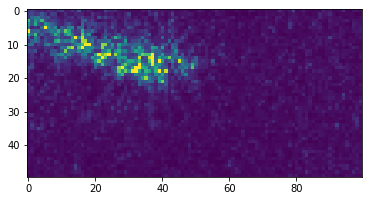

In [16]:
plt.imshow(mi_stack.GetImage(1))
print(np.count_nonzero(mi_stack.GetImage(1)!=mi_stack.GetImage(0, MI_idx=1)))